# Basic analysis of data.

In today's class we will do some basic analysis of weather data.

Our source of data will be the <a href="http://climate.weather.gc.ca/historical_data/search_historic_data_e.html">Canadian Weather Database</a>.

Let's start by looking for the data from Victoria. 

Let's start by downloading the data and checking to see that we have a "full set". 

In [1]:
## Let's start by loading all the weather data, storing it in a list of dictionaries. An element of 
## this list will consist of the weather file headers, turned into a dict-object.  

## There will also be an additional weather-table key that will contain a list of dict objects. 
## containing the data the from a line of the file. 

import datetime as dt
import os as os
import fnmatch as fn
from operator import itemgetter

wsubdir = fn.filter(os.listdir('.'), "w.*")
print("Weather subdirectories:", wsubdir)

## each file is of the form "key", "data" for several lines, then a blank space
## "Legend" then several (ignorable) lines, then a blank space
## "keys" separated by commas then
## remaining lines are the key values for each measurement. 

masterList = [] ## list of weather station dict objects

for wd in wsubdir:
    files = fn.filter(os.listdir(wd), "eng-daily*.csv")
    for wdf in files:
        with open('./'+wd+'/'+wdf, encoding="UTF-8") as f:
            blanks=0
            content = f.readlines()
            FD = dict() ## file dict head.
            FL = [] ## file list.
            keys = []
            for LN in content:
                PL = LN.replace(u'\ufeff','').split(",")
                for i in range(len(PL)): # this removes the quotes around the numbers.
                    PL[i] = PL[i].translate({ord(c): None for c in '"\n'})
                if len(PL)==1 and PL[0]=='':
                    blanks+=1
                    if blanks==2 and PL[0]=='':
                        continue
                ## if blanks==0 we need to build the main dict
                ## if blanks==1 we ignore
                ## if blanks==2 we build the data.
                if blanks==0:
                    FD[PL[0]] = PL[1]
                    if PL[0]=="Station Name":
                        FD["Data"] = []
                if blanks==2:
                    if PL[0]=="Date/Time":
                        keys = PL
                    else:
                        FD["Data"].append( { keys[i] : PL[i] for i in range(len(keys)) } )
            masterList.append(FD)        

## make set of "Station Name"s. 
## use it to merge common station names into one (more useful) masterList.
sNames = { x['Station Name'] for x in masterList}
print("Station names:", sNames)

## return index of list of dict if dict keyed-element exists, -1 otherwise
def indIfExists(LOD, keyname, value):
    for i in range(len(LOD)):
        if LOD[i][keyname] == value:
            return i
    return -1

## run through masterlist, if that airport exists in mList we merge, if not, we copy it over.
mList = []
while len(masterList)>0:
    I = indIfExists(mList, 'Station Name', masterList[-1]['Station Name'])
    if I<0:
        mList.append(masterList.pop())
    else:
        mList[I]["Data"].extend(masterList.pop()["Data"])

## run through the weather station data, replace the date record with a datetime object
for WS in mList:
    badItems = set()
    for i in range(len(WS["Data"])):
        ## Let's convert the dict from strings to appropriate datetime and float objects
        ## dates with bad data we will flag and remove.
        for key, value in WS["Data"][i].items():
            if key=="Date/Time":
                WS["Data"][i][key] = dt.datetime.strptime(value, "%Y-%m-%d")
            elif key in [ 'Min Temp (°C)', 'Total Precip (mm)',  \
                          'Max Temp (°C)', 'Mean Temp (°C)']:
                try:
                    WS["Data"][i][key] = float(value)
                except:
                    badItems.add( i )
    #print(len(WS["Data"]), end=" ")
    WS["Data"] = [WS["Data"][i] for i in range(len(WS["Data"])) if i not in badItems]
    #print(len(WS["Data"]), "\n")
    WS["Data"] = sorted(WS["Data"], key=itemgetter("Date/Time"))

## now let's check for gaps.  We run through the weather station date and check the next day 
## is the previous day + one day.  If not, we start a new interval. 
print("Data intervals: ")
for WS in mList:
    print(WS['Station Name'], end=" ")
    ## find maximal consecutive date interval in data, then move on.
    i0 = 0 ## start interval
    i1 = 0 ## end interval
    ## if date interval [i0,i1] can be expanded to be consecutive, do it.
    ## if not, and if i1 not end of list, move to [i1+1,i1+1] and repeat
    while i1+1 != len(WS['Data']):
        ## if we can increment i1 and keep [i0,i1] consecutive, do it.
        if WS['Data'][i1+1]["Date/Time"]-WS['Data'][i0]["Date/Time"] != dt.timedelta(1+i1-i0):
            ## not consecutive. Move on.
            print(WS['Data'][i0]["Date/Time"].date(), "--", WS['Data'][i1]["Date/Time"].date(), "/ ", end='')
            i0 = i1+1
            i1 = i1+1
        else:
            i1 = i1+1
    print(WS['Data'][i0]["Date/Time"].date(), "--", WS['Data'][i1]["Date/Time"].date()) 
    

Weather subdirectories: ['w.sask', 'w.vic']
Station names: {'SASKATOON SRC', 'VICTORIA INTL A', "SASKATOON DIEFENBAKER INT'L A", "VICTORIA INT'L A"}
Data intervals: 
VICTORIA INT'L A 1970-01-01 -- 1992-12-05 / 1992-12-07 -- 1992-12-17 / 1992-12-19 -- 1992-12-27 / 1992-12-30 -- 1992-12-30 / 1993-01-01 -- 1993-01-04 / 1993-01-06 -- 1993-01-09 / 1993-01-11 -- 1993-01-19 / 1993-01-21 -- 1993-01-28 / 1993-01-30 -- 1993-02-01 / 1993-02-03 -- 1993-02-06 / 1993-02-08 -- 1993-02-08 / 1993-02-10 -- 1993-02-18 / 1993-02-21 -- 1993-03-04 / 1993-03-06 -- 1993-03-15 / 1993-03-17 -- 1993-03-18 / 1993-03-20 -- 1993-04-13 / 1993-04-15 -- 1993-05-02 / 1993-05-04 -- 1993-05-04 / 1993-05-06 -- 1993-05-23 / 1993-05-25 -- 1993-06-06 / 1993-06-09 -- 1993-08-06 / 1993-08-08 -- 1993-08-14 / 1993-08-16 -- 1993-10-20 / 1993-10-23 -- 1993-11-10 / 1993-11-12 -- 1993-11-27 / 1993-11-29 -- 1993-12-27 / 1993-12-30 -- 1996-05-04 / 1996-05-06 -- 1997-11-18 / 1997-11-20 -- 1998-02-25 / 1998-02-27 -- 2004-01-07 / 2004-01

<IPython.core.display.Javascript object>


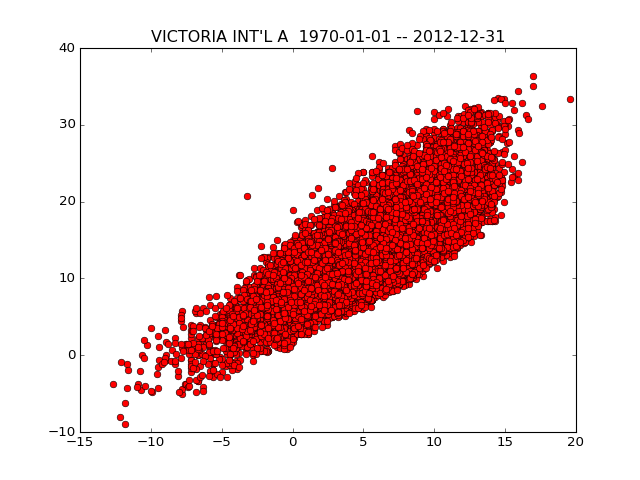

In [53]:
## let's do a max vs. min daily temp plot for Victoria

import matplotlib.pyplot as plt

%matplotlib nbagg
plt.close()

k=0

xp = [x['Min Temp (°C)'] for x in mList[k]['Data']]
yp = [x['Max Temp (°C)'] for x in mList[k]['Data']]
plt.title(mList[k]['Station Name']+"  "+str(mList[k]['Data'][0]['Date/Time'].date())+" -- "+\
          str(mList[k]['Data'][-1]['Date/Time'].date()))

plt.plot(xp, yp, 'ro')

In [63]:
xpl = []
ypl = []
for i in range(4):
    xpl.append(np.array([x['Min Temp (°C)'] for x in mList[i]['Data']]))
    ypl.append(np.array([x['Max Temp (°C)'] for x in mList[i]['Data']]))


In [67]:
import sys
expaths = ["/usr/lib/python3/dist-packages", "/usr/local/lib/python3.5/dist-packages"]
for xp in expaths:
    if (xp not in sys.path):
        sys.path.append(xp)
        
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Create a trace
trace = [go.Scattergl(x=xpl[i], y=ypl[i], mode='markers', name=mList[i]['Station Name']) for i in range(4)]
data = trace

# Plot and embed in ipython notebook!
iplot(data, filename='basic-scatter')


In [3]:
print(mList[0]['Station Name'])
print(mList[0].keys())
print(mList[0]['Data'][0].keys())
print(mList[0]['Data'][0]['Date/Time'].date())
print(mList[0]['Data'][-1]['Date/Time'].date())

print(mList[k]['Data'][-1]['Date/Time'])
print(mList[k]['Data'][-1]['Date/Time'].year)
print( (mList[k]['Data'][-1]['Date/Time'].year - mList[k]['Data'][0]['Date/Time'].year )//10 )
print(len(mList[0]['Data']))

VICTORIA INT'L A
dict_keys(['Station Name', 'Climate Identifier', 'TC Identifier', 'Elevation', 'Province', 'Longitude', 'Data', 'WMO Identifier', 'Latitude'])
dict_keys(['Total Precip Flag', 'Data Quality', 'Total Rain Flag', 'Heat Deg Days Flag', 'Dir of Max Gust Flag', 'Total Precip (mm)', 'Cool Deg Days Flag', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Max Temp Flag', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Day', 'Total Snow Flag', 'Spd of Max Gust Flag', 'Snow on Grnd (cm)', 'Mean Temp Flag', 'Snow on Grnd Flag', 'Min Temp Flag', 'Total Rain (mm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)', 'Month', 'Min Temp (°C)', 'Year', 'Date/Time', 'Max Temp (°C)'])
1970-01-01
2012-12-31
2012-12-31 00:00:00
2012
4
15671


In [ ]:
## Let's try for a more comparative plot.  Victoria in the 70's vs. 80's vs 90's cs 00's
plt.close()

fig, ax = plt.subplots()

k=3

Xp = [[x['Min Temp (°C)'] for x in mList[k]['Data'] if \
       (x['Date/Time'].year - mList[k]['Data'][0]['Date/Time'].year)//10 == gn]\
      for gn in range( 1 + (mList[k]['Data'][-1]['Date/Time'].year - mList[k]['Data'][0]['Date/Time'].year )//10)]

Yp = [[x['Max Temp (°C)'] for x in mList[k]['Data'] if \
       (x['Date/Time'].year - mList[k]['Data'][0]['Date/Time'].year)//10 == gn]\
      for gn in range( 1 + (mList[k]['Data'][-1]['Date/Time'].year - mList[k]['Data'][0]['Date/Time'].year )//10)]

plt.title(mList[k]['Station Name']+"  "+str(mList[k]['Data'][0]['Date/Time'].date())+" -- "+\
          str(mList[k]['Data'][-1]['Date/Time'].date()))

cI = ['ro', 'bo', 'go', 'co', 'yo']
lI = ['1970s', '1980s', '1990s', '2000s', '2010s']

for i in range(len(Xp)):
    plt.plot(Xp[i], Yp[i], cI[i], label = lI[i])

legend = ax.legend(loc='upper left')

plt.show()

<IPython.core.display.Javascript object>


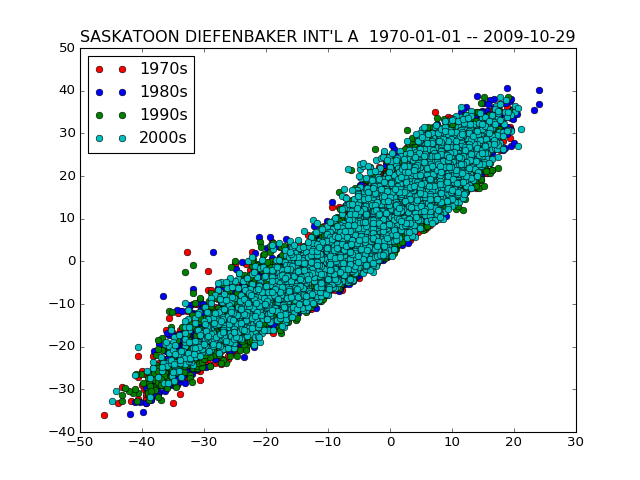

In [ ]:
## rain in one vs. other town on same day. 
#VICTORIA INT'L A
#vs
#SASKATOON DIEFENBAKER INT'L A

## run through the weather station data, replace the date record with a datetime object
for WS in mList:
    badItems = set()
    for i in range(len(WS["Data"])):
        ## Let's convert the dict from strings to appropriate datetime and float objects
        ## dates with bad data we will flag and remove.
        for key, value in WS["Data"][i].items():
            if key=="Date/Time":
                WS["Data"][i][key] = dt.datetime.strptime(value, "%Y-%m-%d")
            elif key in [ 'Min Temp (°C)', 'Total Precip (mm)',  \
                          'Max Temp (°C)', 'Mean Temp (°C)']:
                try:
                    WS["Data"][i][key] = float(value)
                except:
                    badItems.add( i )
    #print(len(WS["Data"]), end=" ")
    WS["Data"] = [WS["Data"][i] for i in range(len(WS["Data"])) if i not in badItems]
    #print(len(WS["Data"]), "\n")
    WS["Data"] = sorted(WS["Data"], key=itemgetter("Date/Time"))

# Least squares

A useful technique for finding linear (and other) relations between variables is called *least squares*. 

Assume you have some data points $(x_i, y_i)$ for $i = 1, 2, \cdots, n$.  And you want to find a *best* fit function of the form

$$y \simeq F(x) = \sum_{i=1}^m c_i f_i(x)$$

with the functions $f_i : \mathbb R \to \mathbb R$ picked by you, i.e. we want to interpolate our data as a linear combination of some functions that we have decided upon *ahead of time*.  

Given a choice of constants $\{c_i : i = 1, 2, \cdots, m\}$ the **Total Error** (squared) of the approximation is defined as:

$$E^2 = \sum_{i=1}^n (F(x_i) - y_i)^2 $$

Since $F$, $x_i$, and $y_i$ are given, we can think of $E^2$ as a function of the coefficients $(c_1, c_2, \cdots, c_m)$.  By calculus the minimum occurs at a critical point, which is when:

$$\frac{\partial E^2}{\partial c_1} = \frac{\partial E^2}{\partial c_2} = \cdots = \frac{\partial E^2}{\partial c_m} = 0 \hskip 1cm \star$$

which is a system of $m$ linear equations in the $m$ variables $\{c_1, c_2, \cdots, c_m\}$. 

Specifically, 

$$\frac{\partial E^2}{\partial c_k} = \sum_{i=1}^n 2(F(x_i)-y_i)f_k(x_i), \hskip 1cm k=1,2,\cdots, m$$
which allows us to express the linear system $\star$ as

$$\sum_{i,j=1}^{n,m} c_jf_j(x_i)f_k(x_i) = \sum_{i=1}^n y_i f_k(x_i), \hskip 1cm k=1,2,\cdots,n$$
which in turn is the matrix equation

$$AA^T \vec c = A \vec y$$
where 
$$A = \pmatrix{f_1(x_1) & f_1(x_2) & \cdots & f_1(x_n) \cr f_2(x_1) & f_2(x_2) & \cdots & f_2(x_n) \cr . & . & & . \cr  . & . & & . \cr f_m(x_1) & f_m(x_2) & \cdots & f_m(x_n)}$$
$\vec y = \pmatrix{y_1 \cr y_2 \cr . \cr . \cr y_n}$, and 
$\vec c = \pmatrix{c_1 \cr c_2 \cr . \cr . \cr c_m}$.

Thus the solution is

$$ \vec c = (AA^T)^{-1} A \vec y$$

which exists when the $m \times m$ matrix $AA^T$ is invertible, which is equivalent to saying $A$ has rank $m$. One way to think of this is that the functions $f_1, \cdots, f_m$ should be linearly independent and this linear independence remains when you restrict these functions to the finite set $\{x_1, x_2, \cdots, x_n\}$. 

Let's begin applying these techniques to our weather data.  Say we want to compute a linear best-fit approximation to the min vs. max temperature plots. 

$$y = c_1 x + c_0$$

i.e. $m=2$ and $n$ is the number of data points.  Our function $f_1(x) = x$ and $f_0(x) = 1$.  So our matrix $A$ is

$$A = \pmatrix{1 & 1 & \cdots & 1 \cr x_1 & x_2 & \cdots & x_n}$$

Let's solve for $\vec c$. 

In [31]:
import numpy as np
plt.close()

k=3

xp = [x['Min Temp (°C)'] for x in mList[k]['Data']]
yp = [x['Max Temp (°C)'] for x in mList[k]['Data']]

A = np.matrix([[1.0, x] for x in xp]).T
y = np.matrix([y for y in yp]).T

c = np.matmul(np.matmul(np.linalg.inv(np.matmul(A,A.T)), A), y) 
#print(c)
## c_0 = 8.06, c_1 = 1.13
c0=c[0,0]
c1=c[1,0]

<IPython.core.display.Javascript object>


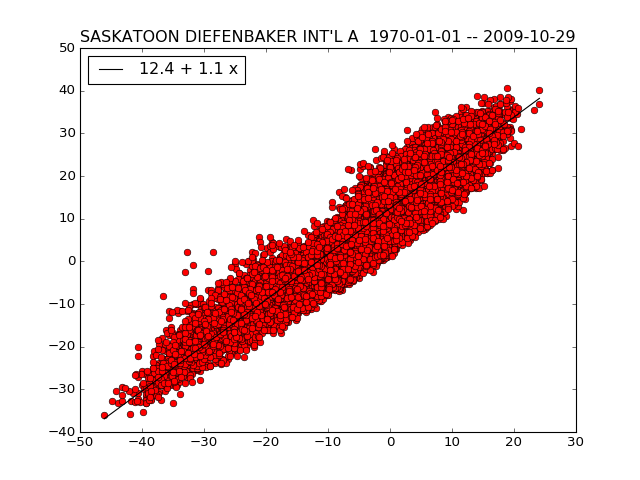

In [32]:
plt.close()

fig, ax = plt.subplots()

plt.title(mList[k]['Station Name']+"  "+str(mList[k]['Data'][0]['Date/Time'].date())+" -- "+\
          str(mList[k]['Data'][-1]['Date/Time'].date()))

plt.plot(xp, yp, 'ro')

plt.plot([min(xp), max(xp)], [c0+c1*min(xp), c0+c1*max(xp)], color="black", label=str("%1.1f + %1.1f x" % (c0,c1)))

legend = ax.legend(loc='upper left')

plt.show()

In [33]:
## what happens if we put in a quadratic term?

A = np.matrix([[1.0, x, x*x] for x in xp]).T
y = np.matrix([y for y in yp]).T

c = np.matmul(np.matmul(np.linalg.inv(np.matmul(A,A.T)), A), y) 

print(c)

[[  1.20100549e+01]
 [  1.11700478e+00]
 [  3.06781400e-03]]
